# I- Smoothing

## Introduction

In the previous two lessons, we learned that time series data is data that is measured at equally-spaced intervals, that time series data can be decomposed into trend, seasonality, and residuals, and that many time series models require the data to be stationary in order to make forecasts.  

Now we'll build upon that knowledge by exploring another important concept called **smoothing**.

In this lesson, we will explore the idea of smoothing a time series. Specifically, we'll discuss what smoothing is and why it is necessary.

As before, we'll generate datasets from scratch to help you grasp the advantages of smoothing. 

## Learning Outcomes
You should walk away from this tutorial with:
1. A practical understanding of smoothing and why it is necessary.
2. Several common smoothing techniques.
3. A basic understanding of how to smooth time series data with Python and generate forecasts.

## Imports

In [65]:
%matplotlib inline

import sys
import statsmodels as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Python & Library Versions

In [66]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__),
            ("statsmodels", ss.__version__) )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)] 

library    version
------------------
matplotlib  3.2.1
numpy       1.18.4
pandas      1.0.3
statsmodels 0.12.1


### What is Smooothing?
Any data collection process is subject to noise. Oftentimes this noise can obscure useful patterns. Smoothing is a well-known and oft used technique to extract those patterns. 

Smoothing comes in two flavors:
1. Simple 
2. Exponential 

We'll explore these concepts more deeply in a moment. However, before we do, let's kick things off with the stationary data we discussed in the last lesson on stationary time series.

In [4]:
# reproducibility
np.random.seed(42)

# data
time = np.arange(100)
stationary = np.random.normal(loc=0, scale=1.0, size=len(time))

By now you should know that you should always visually inspect your time series with a run-sequence plot. 
> Again, we'll create a *run_sequence_plot* function to make plotting throughout this tutorial less cumbersome.

In [5]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

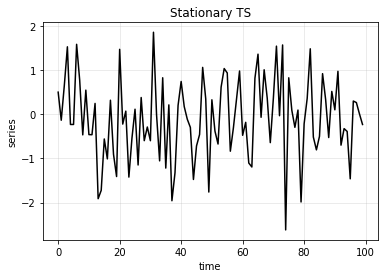

In [6]:
run_sequence_plot(time, stationary, 
                  title="Stationary TS")

Great, now we can discuss the two types of smoothing. 

---

##  Common Smoothing Techniques
This may surprise you but there are many techniques for smoothing data. 

The ones we'll discuss in this tutorial are:
1. Simple Smoothing
2. Moving Average Smoothing
3. Exponential Smoothing

### 1. Simple Smoothing
Simple smoothing is the most obvious place to start. 

Consider the stationary data above. How would you go about extracting information from this series? 

Naturally, your inclination may be to calculate the mean and use that as an estimate to represent the series. 

Let's try that.

In [7]:
# find mean of series
stationary_time_series_avg = np.mean(stationary)

# create array composed of mean value and equal to length of time array
sts_avg = np.full(shape=len(time), fill_value=stationary_time_series_avg, dtype='float')

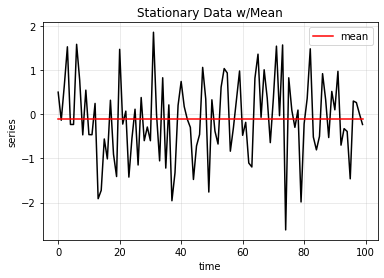

In [8]:
run_sequence_plot(time, stationary,
                  title="Stationary Data w/Mean")
plt.plot(time, sts_avg, 'r', label="mean")
plt.legend();

We need a way to measure how far off our estimate is from reality. A common way to do this with continuous data is by calculating Mean Squared Error (MSE). 

The formula for MSE is:  $MSE = \frac{1}{n}\sum_{i=0}^{n} (observed_{i} - estimate_{i})^2$

Let's walk through a quick example to make sure you understand what's happening.

Say we an array of observed values [0, 1, 2, 3] and our estimate is the array [1, 1, 1, 1]. 

We calculate MSE like this: $(0-1)^{2} + (1-1)^{2} + (2-1)^{2} + (3-1)^{2}$ which is 6. 

Say we had another estimate [0, 0, 0, 0]. Let's calculate MSE once again.

The MSE is simply $0^{2} + 1^{2} + 2^{2} + 3^{2}$ which is 14. 

Having MSE gives us a way to compare different estimates to see which is best. In this case, the array of 1's is a far more accurate representation of the data than the array of 0's. We know this because the MSE is lower for the array of 1's. 

This idea of measuring how a model is performing crops up throughout machine learning and we will see its power later in this tutorial.

Now let's create a function to calculate MSE and discuss smoothing when a trend is present.

#### MSE Function
Let's create a Mean Squared Error function that we can use going forward.

In [9]:
def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

Let's test the **mse** function.

In [10]:
zeros = mse(np.array([0, 1, 2, 3]), np.array([0, 0, 0, 0]))
print(zeros)

14


In [11]:
ones = mse(np.array([0, 1, 2, 3]), np.array([1, 1, 1, 1]))
print(ones)

6


#### Trend

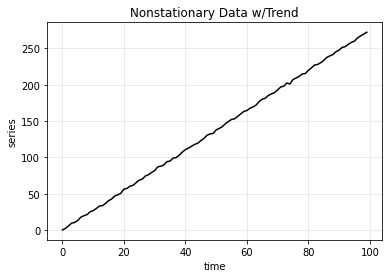

In [12]:
trend = (time * 2.75) + stationary
run_sequence_plot(time, trend,
                  title="Nonstationary Data w/Trend")

It's clear in the plot above that there is an upward trend. Suppose we take the mean of the series again. 

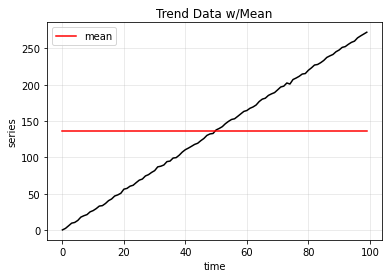

In [13]:
# find mean of series
trend_time_series_avg = np.mean(trend)

# create array of mean value equal to length of time array
trend_avg = np.full(shape=len(time), fill_value=trend_time_series_avg, dtype='float')

run_sequence_plot(time, trend,
                  title="Trend Data w/Mean")
plt.plot(time, trend_avg, 'r', label="mean")
plt.legend();

### 2. Moving Average Smoothing

The easiest way to understand moving average is by example. 

Say we have the values [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]. 

The first step is to select a window size. We'll choose a size of three arbitrarily. So what happens is we compute the average for the first three values and store the result. We then slide the window over one spot and calculate the average of the next three values. We continue this process until we reach the final observed value. 

Therefore, the window begins with the values [0, 1, 2]. The mean of that sequence is 1 so we store that value [1]. We slide the window over one place to [1, 2, 3] and compute the mean which is 2. We add that value to storage so we have [1, 2]. We continue this process until we reach the last window of size three [7, 8, 9]. We conclude by calculating the mean and storing the result. The result is an array of smoothed values: [1, 2, 3, 4, 5, 6, 7, 8]. 

Here's the cool part. Let's compare MSE for the two possibilities we've discussed thus far. 

In [14]:
# generate data for arrays discussed above
dummy_data = np.arange(10)
dummy_avg = np.mean(dummy_data)
dummy_avg_array = np.full(shape=len(dummy_data), fill_value=dummy_avg, dtype='float')

# calc MSE's
dummy_simple_average_mse = mse(dummy_data, dummy_avg_array)
dummy_smoothed_average_mse = mse(dummy_data[1:-1], np.arange(1, 9))

# print results
print("MSE")
print("-" * 12)
print("Simple: ", dummy_simple_average_mse)
print("Smoothed: ", dummy_smoothed_average_mse)

MSE
------------
Simple:  82.5
Smoothed:  0


Here we start to see the power of smoothing. A simple average of the trend data resulted in an abysmal MSE of 82.5 whereas a smoothed version of this contrived example produced a perfect estimation (MSE of 0). 
> An MSE of 0 is nearly always impossible unless you have toy data like this.

Let's create a moving average function to make this process easier moving forward.
> The guts of this function were taken from [this](https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy#14314054) stackoverflow.

In [15]:
def moving_average(observations, window=3, forecast=False):
    '''returns the smoothed version of an array of observations.'''
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    if forecast:
        return np.insert(cumulative_sum[window - 1:] / window, 0, np.zeros(3))
    else:
        return cumulative_sum[window - 1:] / window

Great, now let's calculate the moving average of the trend data.

In [16]:
smoothed_trend = moving_average(trend, window=3, forecast=False)

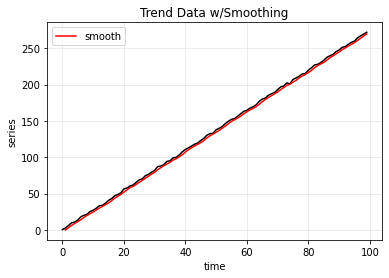

In [17]:
run_sequence_plot(time, trend,
                  title="Trend Data w/Smoothing")
plt.plot(time[1:], np.insert(smoothed_trend,0,0), 'r', label="smooth")
plt.legend();

Not bad at all! You can see the smoothed version picks up the trend rather nicely, far better than the simple average. Now we're getting somewhere.

Let's try the same thing with seasonality.

In [18]:
seasonality = 10 + np.sin(time) * 10
smoothed_seasonality = moving_average(seasonality, window=3, forecast=False)

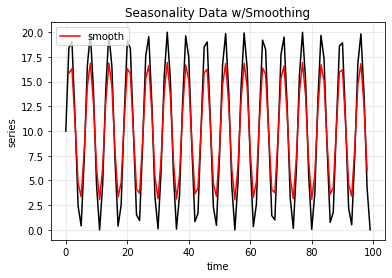

In [19]:
run_sequence_plot(time, seasonality,
                  title="Seasonality Data w/Smoothing")
plt.plot(time[1:-1], smoothed_seasonality, 'r', label="smooth")
plt.legend(loc='upper left');

It's far from perfect but clearly picks up the inherent pattern contained within this seasonal pattern.

Lastly, let's see how moving average handles trend, seasonality, and a bit of noise.

In [20]:
trend_seasonality = trend + seasonality + stationary
smoothed_trend_seasonality = moving_average(trend_seasonality, window=3, forecast=False)

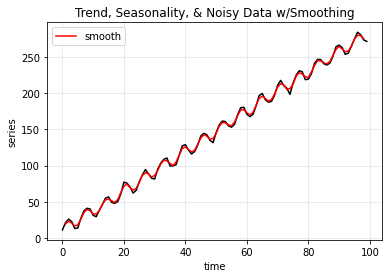

In [21]:
run_sequence_plot(time, trend_seasonality,
                  title="Trend, Seasonality, & Noisy Data w/Smoothing")
plt.plot(time[1:-1], smoothed_trend_seasonality, 'r', label="smooth")
plt.legend(loc='upper left');

Overall this method is doing a decent job on these toy datasets. You can see it's picking up key patterns in the data. However, we've been weighting all observations equally. If you think about time series data, though, you may quickly realize that the most recent observations tend to impact the current to a larger degree than older ones. 

This leads us to another averaging strategy: exponential smoothing.

### 3. Exponential Smoothing
Exponential smoothing is a way to weight observations differently. Specifically, recent observations are weighted moreso than more distant ones. This makes intuitive sense. Think back to the stock market example that we discussed in past lessons. In general, it has been observed that today's price is a good predictor for tomorrow's price. Using an equally weighted smoothing process like the one introduced earlier would dilute that. However, by applying unequal weights to past observations, we can control how much each affects the future forecast. 

Let's make this concrete with an example. 

Say we have the values [1, 2, 4, 16, 256]. 

Instead of pulling out the inherent pattern within a series, let's use these smoothing functions to create forecasts. In other words, we'll apply the smoothing process and use the resulting value as the next data point.

With an equally weighted moving average discussed earlier we'd get a smoothed result that looks like this:

In [22]:
values = np.array([1, 2, 4, 8, 16, 32, 64])
ma_smoothed_vals = moving_average(values, window=3, forecast=True)

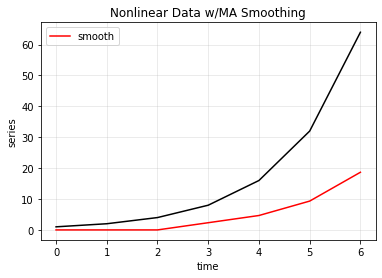

In [23]:
t = np.arange(len(values))
run_sequence_plot(t, values,
                  title="Nonlinear Data w/MA Smoothing")
plt.plot(t, ma_smoothed_vals[:-1], 'r', label="smooth")
plt.legend(loc='upper left');

Now let's weight recent values more aggressively than older values. 

We'll use a simple exponential weighting whereby $w_{1} + w_{2}^2 + w_{3}^3 = 1$. 

This means $w_{1}$ is ~0.543, $w_{2}$ is ~0.294, and $w_{3}$ is ~0.160.

In [24]:
def ewma(observations, forecast=True):
    '''returns the exponentially weighted smoothed version of an array of observations.'''
    weights = np.array([0.160, 0.294, 0.543])
    output = np.zeros_like(observations, dtype='float')
    for i, _ in enumerate(observations):
        if (i == 0) or (i == 1) or (i == len(observations) - 1):
            pass
        else:
            output[i] = np.dot(observations[i-2:i+1], weights)
    if forecast:
        return np.insert(output, 0, 0)
    else:
        return output

In [25]:
ewma_smoothed_vals = ewma(values, forecast=True)

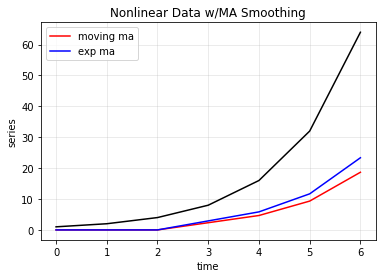

In [26]:
run_sequence_plot(t, values,
                  title="Nonlinear Data w/MA Smoothing")
plt.plot(t, ma_smoothed_vals[:-1], 'r', label="moving ma")
plt.plot(t, ewma_smoothed_vals[:-1], 'b', label="exp ma")
plt.legend(loc='upper left');

You can see both moving average techniques have trouble keeping pace with such an aggressive trend. There's significant lag. This gives us a glimpse into why using moving average techniques alone to detect and forecast trend can be problematic. One thing that is clear, however, is that the exponential weighting does a better job following the trend. 

#### Setting Weights
I chose the weights above for explanatory purposes but there are numerous methods to find the optimal weighting scheme. A full discussion is far beyond the scope of this tutorial. Nonetheless, it is helpful that you be acclimated to the formulation and possible initialization strategies.

The formulation is this: $S_{t} = \alpha*y_{t-1} + (1-\alpha)S_{t-1}$

$S_{t}$ is the smoothed value at time *t*  
$\alpha$ is a smoothing constant  
$y_{t-1}$ is the value of the series at time *t-1*

#### Initialization
There are many initialization strategies. A simple one is to set $S_2$ equal to $y_1$. Another strategy is to find the mean of the first couple of observations. Once you've initialized, you simply use the update rule above to calculate all values. 

Thankfully, you'll never have to actually go through this arduous process. There are great methods in **statsmodels** that will do all this heavy lifting for you. 

#### Setting Alpha
One last comment: choosing the optimal value for $\alpha$ is also taken care of for you by **statsmodels**. A solver uses a metric like MSE to find an $\alpha$ that minimizes that metric. Therefore, you rarely have to choose this value yourself, but at least you have a basic idea as to what's happening under the hood.

#### Three Types of Exponential Smoothing

There are three key exponential smoothing techniques you need to be aware of:
1. Single Exponential Smoothing - no trend or seasonality
2. Double Exponential Smoothing - captures trend
3. Triple Exponential Smoothing - captures trend & seasonality

#### Single Exponential
This method is useful if your data lacks trend and seasonality and you want to approximately track patterns in your data. Furthermore, this method removes the lag associated with the moving average techniques discussed above. 

#### Double Exponential 
Should your data exhibit a trend, you'll want to use this smoothing method. It has all the benefits of Single Exponential with the ability to pickup on trend. 

#### Triple Exponential
Should your data exhibit trend and seasonality, you'll want to use this smoothing method. It has all the benefits of Double Exponential with the ability to pickup on seasonality. 

## Section 3: Smoothed Time Series in Python
We now have the foundation behind us to tackle smoothing in Python. As we've done in the past, we'll leverage statsmodels to do the heavy lifting for us behind the scenes. Therefore, this section is primarily application based. 

We'll use the same trend and seasonality dataset throughout to compare simple average, single, double, and triple exponential smoothing. 

We'll holdout the last 5 samples from the dataset so we can see how each model makes predictions. We'll then compare those to actuals.

#### Train/Test Split

In [27]:
train = trend_seasonality[:-5]
test = trend_seasonality[-5:]

#### Simple Average

In [28]:
# find mean of series
trend_seasonal_avg = np.mean(trend_seasonality)

# create array of mean value equal to length of time array
simple_avg_preds = np.full(shape=len(test), fill_value=trend_seasonal_avg, dtype='float')

# mse
simple_mse = mse(test, simple_avg_preds)

# results
print("Predictions: ", simple_avg_preds)
print("MSE: ", simple_mse)

Predictions:  [145.95522643 145.95522643 145.95522643 145.95522643 145.95522643]
MSE:  86295.31932923789


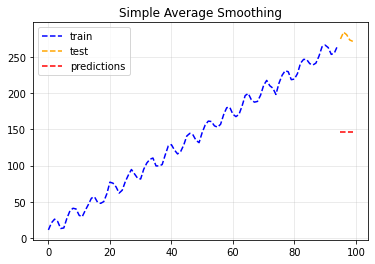

In [29]:
plt.plot(time[:-5], train, 'b--', label="train")
plt.plot(time[-5:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-5:], simple_avg_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Simple Average Smoothing")
plt.grid(alpha=0.3);

**Details:** This is a crude model to say the least, but it's a great model to use as a baseline. In other words, any model you produce moving forward should do much better than this one. 

#### Single Exponential

In [68]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [265.2632637 265.2632637 265.2632637 265.2632637 265.2632637]
MSE:  830.001033618639


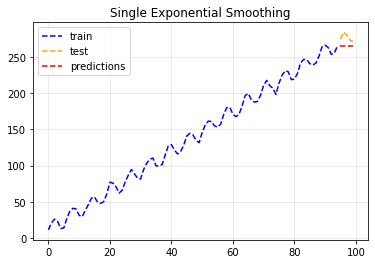

In [69]:
plt.plot(time[:-5], train, 'b--', label="train")
plt.plot(time[-5:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-5:], single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")
plt.grid(alpha=0.3);

**Details:** This is certainly better than the simple average method but it's still pretty crude. Notice how the forecast is a horizontal line. Single Exponential Smoothing cannot pickup on trend or seasonality, which harkens back to mean we calculated for the stationary data way back at the beginning.

#### Double Exponential

In [71]:
from statsmodels.tsa.api import Holt

double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [267.97010709 270.67695073 273.38379437 276.09063801 278.79748165]
MSE:  354.2535066630869


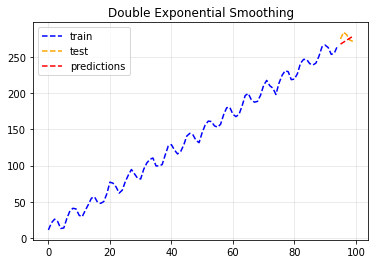

In [72]:
plt.plot(time[:-5], train, 'b--', label="train")
plt.plot(time[-5:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-5:], double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")
plt.grid(alpha=0.3);

**Details:** Double Exponential Smoothing can pickup on trend, which is exactly what we see here. This is a significant leap but no quite where we need to be.

#### Triple Exponential

In [74]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=13).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [277.27549012 282.58451837 282.4023303  276.6731441  274.78363421]
MSE:  27.033149640183524


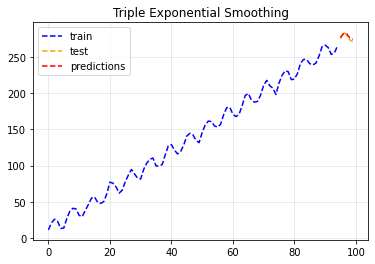

In [35]:
plt.plot(time[:-5], train, 'b--', label="train")
plt.plot(time[-5:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-5:], triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

**Details:** Triple Exponential Smoothing pickups trend and seasonality. This is clear in the plot above. This approach makes the most sense for this data.

#### Comparison

In [36]:
data_dict = {'MSE':[simple_mse, single_mse, double_mse, triple_mse]}
df = pd.DataFrame(data_dict, index=['simple', 'single', 'double', 'triple'])
print(df)

                 MSE
simple  86295.319329
single    830.001034
double    354.253507
triple     27.033150


## Summary

In this assignment you should have learned: 
1. What smoothing is and why it is necessary.
2. Several common smoothing techniques.
3. A basic understanding of how to smooth time series data with Python and generate forecasts.

Congratulations, that concludes this lesson.

# II- Autocorrelation

## Introduction

In the previous three lessons, you learned several fundamental time series concepts like stationarity and smoothing. Now we'll build upon that knowledge by digging into yet another important concept called **autocorrelation**.

## Learning Outcomes
You should walk away from this tutorial with:
1. A practical understanding of Moving Average (MA) models.
2. A basic understanding of the Autocorrelation Function (ACF).
3. Insight into choosing the order *q* of MA models.
4. A practical understanding of Autoregressive (AR) models.
5. A basic understanding of the Partial Autocorrelation Function (PACF).
6. Insight into choosing the order *p* of AR models.

## Imports

In [75]:
%matplotlib inline

import sys
import statsmodels as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

## Section 1: Moving Average (MA) & MA Models 

In this lesson, we will revisit moving average smoothing and explore the idea of moving average models. Please be aware that these two concepts are not equivalent. Each serves a different, important function.

### What is a Moving Average?
Moving average is perhaps one of the most obvious and simplest techniques you can use to capture local changes in time series data as well as provide forecasts. In fact, we explored MA in some detail last lesson. We discussed simple and exponential smoothing. We also discussed single, double, and triple exponential smoothing. If you're fuzzy about any of those terms, please go back and review now. 

Let's build upon this knowledge by going a bit deeper. 

Recall that the forecast value $\hat{y}_{t+1} = \frac{y_t + y_{t-1} + ... + y_{t-m+1}}{m}$

It's worth pondering that formula for a minute. While easy to understand, one of its properties may not be obvious. What's the lag associated with this technique? Think it through. 

The answer is $\frac{(m+1)}{2}$. For example, say you're averaging the past 5 values to make the next prediction. Then local changes will yield a lag of $\frac{5+1}{2} = 3$ periods. Clearly, the lag increases as you increase the the window size for averaging. 

You may think to yourself, "Well, I'll just use a small window size." Doing so will create a more responsive model. However, a window size that's too small will chase noise in the data as opposed to extracting the pattern. As with most things in machine learning, there is a tradeoff between the two. The best answer lies somewhere between and requires careful tuning to determine which setup is best for a given dataset. 

Let's generate some toy data and apply a moving average with different window sizes to see that what we discussed is in fact true. 

In [76]:
# reproducibility
np.random.seed(42)

# time component
time = np.arange(100)

# data
noise = np.random.normal(loc=0, scale=6.5, size=len(time))
trend = time * 2.75
seasonality = 10 + np.sin(time * 0.25) * 20
data = trend + seasonality + noise

Yet another friendly reminder that you should always visually inspect your time series with a run-sequence plot. 
> We'll leverage the *run_sequence_plot* function to make plotting throughout this tutorial less cumbersome.

In [77]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-', label="actual")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.legend();

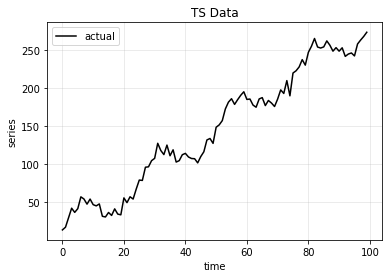

In [78]:
run_sequence_plot(time, data, title="TS Data")

Great, now we need a moving average function. Thankfully, pandas has a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html) function we can leverage.

We'll try three window sizes: 3, 5, 9. Then we'll plot the results.

In [79]:
series = pd.Series(data)

# case with lag of 2
lag_2 = series.rolling(window=3).mean()

# case with lag of 3
lag_3 = series.rolling(window=5).mean()

# case with lag of 5
lag_5 = series.rolling(window=9).mean()

# case with lag of 10
lag_10 = series.rolling(window=19).mean()

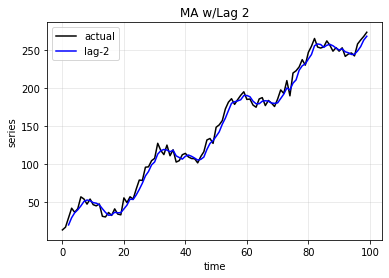

In [80]:
run_sequence_plot(time, data, title="MA w/Lag 2")
plt.plot(time, lag_2, 'b-', label="lag-2")
plt.legend();

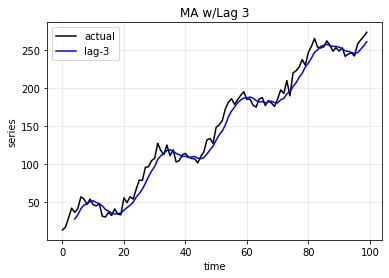

In [81]:
run_sequence_plot(time, data, title="MA w/Lag 3")
plt.plot(time, lag_3, 'b-', label="lag-3")
plt.legend();

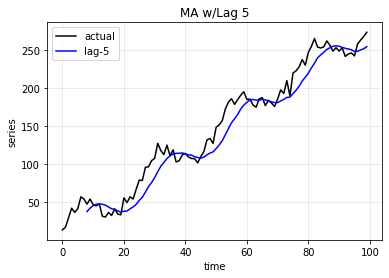

In [82]:
run_sequence_plot(time, data, title="MA w/Lag 5")
plt.plot(time, lag_5, 'b-', label="lag-5")
plt.legend();

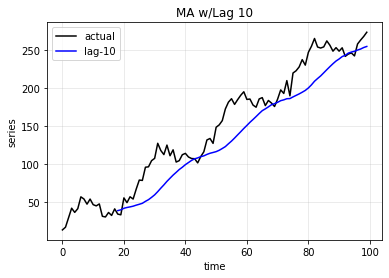

In [84]:
run_sequence_plot(time, data, title="MA w/Lag 10")
plt.plot(time, lag_10, 'b-', label="lag-10")
plt.legend();

The tradeoff is responsiveness versus smoothing capabilities. Let's make this clearer by plotting the three moving average curves sans actual data.

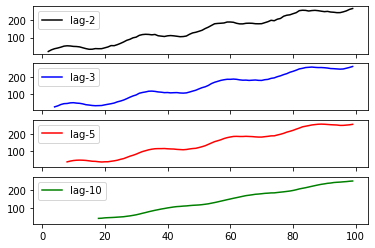

In [85]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=True)
axes[0].plot(time, lag_2, 'k-', label="lag-2")
axes[0].legend()
axes[1].plot(time, lag_3, 'b-', label="lag-3")
axes[1].legend()
axes[2].plot(time, lag_5, 'r-', label="lag-5")
axes[2].legend()
axes[3].plot(time, lag_10, 'g-', label="lag-10")
axes[3].legend();

### MA Models != Moving Average Smoothing
An important distinction is that a moving average model is not the same thing as moving average smoothing. What we did above was smoothing. It has important properties already discussed. However, we turn our attention to moving average models, which are a completely different beast.

Moving average smoothing is useful for estimating trend and seasonality of past data. MA models, on the other hand, are a useful forecasting model that regresses on past forecast errors in order to forecast future values. It is easy to lump the two techniques together, but they serve very different functions. 

### MA Model Specifics
A MA model is defined by this equation: $y_t=c+e_t+θ_1e_{t−1}+θ_2e_{t−2}+⋯+θ_qe_{t−q}$ where $e_t$ is white noise. The value $c$ is a constant value and the $\theta$'s are coefficients, not unlike those found in linear regression.

Fitting a MA models is quite involved and requires iterative procedures. The details are beyond the scope of this lesson. However, statsmodels has this functionality built in so we can build a model with minimal effort. Let's take a look.

### MA Models with Statsmodels

In [88]:
from statsmodels.tsa.arima_model import ARMA

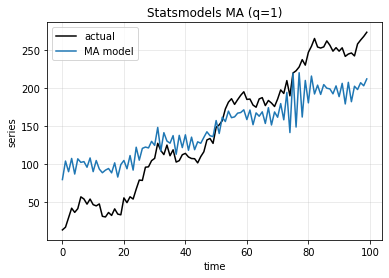

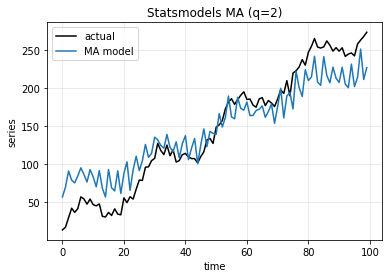

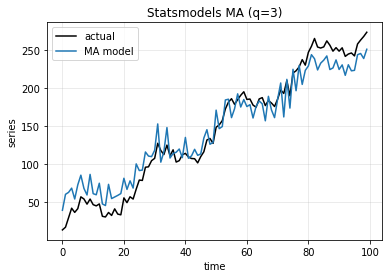

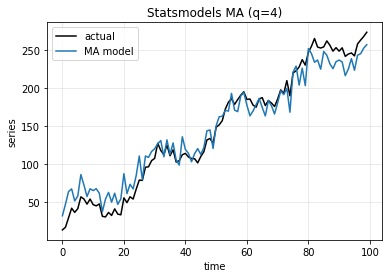

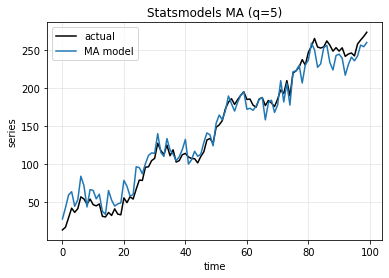

In [92]:
import warnings
warnings.filterwarnings("ignore")


# plot different orders (q's)
for i in range(1,6):
    model = ARMA(data, (0,i)).fit()
    run_sequence_plot(time, data, title="Statsmodels MA (q={})".format(i))
    plt.plot(time, model.predict(start=1, end=100), label="MA model")
    plt.legend()
    plt.show();

Now that we understand the basics of MA models, let's turn our attention to selecting the proper order called *q*.

## Section 2: The Autocorrelation Function (ACF)
There's a crucial question we need to answer: How do you choose the order, known as *q*, of the MA model?

In order to answer that question, we need to understand the Autocorrelation Function (ACF). 

Let's start by showing an example ACF plot for our dataset called *data*.

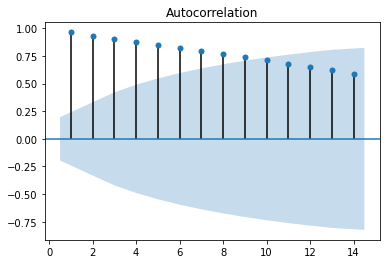

In [93]:
from statsmodels.graphics.tsaplots import plot_acf

fig = plot_acf(data, lags=range(1,15), alpha=0.05)

An explanation is in order. First, the blue region represents a confidence interval. Alpha in this case was set to 0.05 (95% confidence interval). This can be set to whatever float value you require. See the **plot_acf** function for details. 

The stems represent lagged correlation values. In other words, a lag of 1 correlates almost perfectly with the current endogenous value. A lag of 2 correlates nearly but not quite as well. And so on. Remember that we're regressing on past forecast errors; that's the correlation we're inspecting here. 

Correlations outside of the confidence interval are statistically significant whereas the others are not. You can use this plot to choose the value of *q* to include in your MA model. One key thing to note is that **MA models require stationarity**. You should see correlations drop quickly. If they don't, that's a sign that your data is not stationary, as we see here.

In the interest of rigor, we'll test our data with the Augmented Dickey-Fuller test, though we know how this particular data was generated (i.e. it has trend and seasonality). Therefore, it is not stationary. We can, however, transform it by applying a difference and checking for stationarity once again.

In [94]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data)
print(pvalue)

0.9562340501068858


A p-value that high means we must fail to reject the null that this data is nonstationary - as we knew all along. Now let's apply three differences and check again.

In [95]:
difference = data[:-1] - data[1:]
difference2 = difference[:-1] - difference[1:]

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(difference2)
print(pvalue)

0.002099608424396198


We're stationary now!

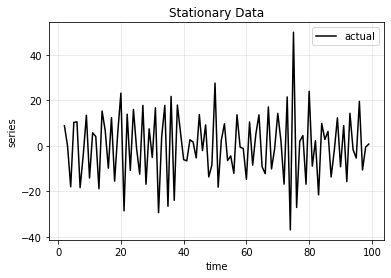

In [96]:
run_sequence_plot(time[2:], difference2, title="Stationary Data")

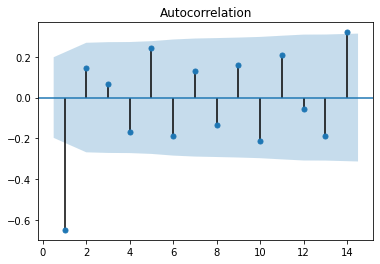

In [97]:
fig = plot_acf(difference2, lags=range(1,15), alpha=0.05)

The plot above shows AR(1) is most appropriate.
> See [here](https://people.duke.edu/~rnau/411arim2.htm) for an in-depth explanation.

That concludes our discussion of MA models. Let's now turn our attention to AR models.

## Section 3: Autoregressive (AR) Models
In this lesson, we will explore the idea of autoregressive models and how to determine the proper order with the Partial Autocorrelation Function (PACF). 

### What is an Autoregressive Model?
AR models are similar to MA models with one key distinction. MA models regress on past forecast errors in order to forecast future values. On the other hand, AR models regress on actual past values, not past errors. 

This is the first order or **AR(1)** formula you should know: $y_t = \beta_0 + \beta_1y_{t-1}+\epsilon_t$

The $\beta$'s are just like those in linear regression and $\epsilon$ is irreducible error.

A second order or **AR(2)** would look like this: $y_t = \beta_0 + \beta_1y_{t-1}+\beta_2y_{t-2}+\epsilon_t$

The pattern of adding another coefficient and another past term continues to whichever order you choose. Choosing that order called *p* is something we will discuss shortly.

In the meantime, let's walk through a basic autocorrelation example. We'll generate our own data so we know the generative process.

In [98]:
# seed to start series
seed = 14

# reproducibility
np.random.seed(123)

# create autocorrelated data
lagged = np.empty_like(time, dtype='float')
for t in time:
    lagged[t] = seed + np.random.normal(loc=0, scale=2.5, size=1)
    seed = lagged[t]
    if t > 0:
        lagged[t] = lagged[t] + (0.7 * lagged[t-1])

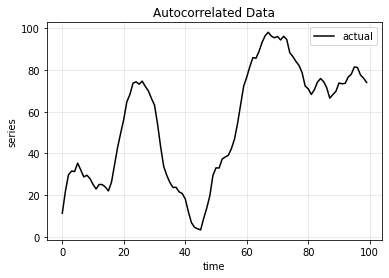

In [99]:
run_sequence_plot(time, lagged, title="Autocorrelated Data");

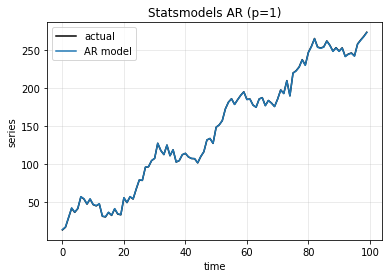

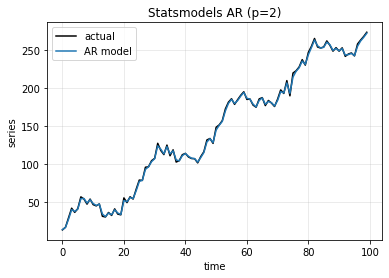

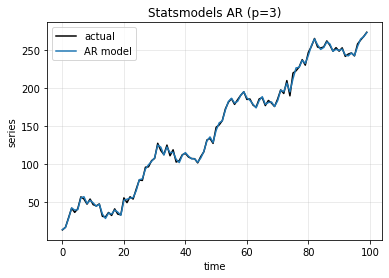

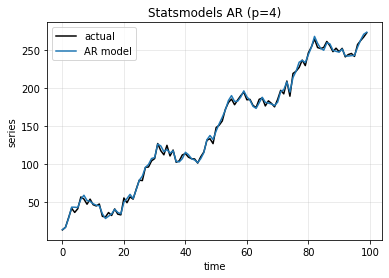

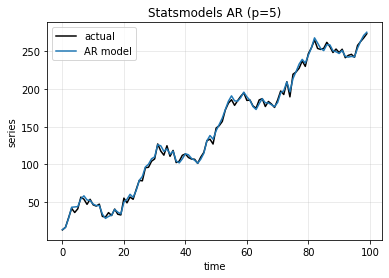

In [100]:
# plot different orders (q's)
for i in range(1,6):
    model = ARMA(data, (i,0)).fit()
    run_sequence_plot(time, data, title="Statsmodels AR (p={})".format(i))
    plt.plot(time, model.predict(start=1, end=100), label="AR model")
    plt.legend()
    plt.show();

---

## Section 4: The Partial Autocorrelation Function (PACF)


Choosing the order *p* of the AR model is important. Thankfully, there's a useful plot called the Partial Autocorrelation Function plot that can help us with that task. 

Let's look at an example.

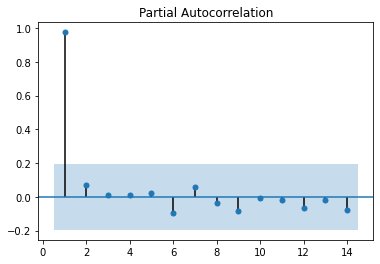

In [101]:
from statsmodels.graphics.tsaplots import plot_pacf

fig = plot_pacf(data, lags=range(1,15), alpha=0.05)

This plot is quite easy to read. First off, the blue region once again is the 95% confidence interval. The ACF is a way to measure the linear relationship between a current observation and observations at previous time periods. It turns out we are really only interested in the relationship between the current observation and a past value determined by a lag value. We often don't care about the relationship of values between the two, so we transform them to obtain the PACF. The key takeaway is the PACF is a useful tool for identifying the order of the AR model.

This example shows that an AR(1) model is most appropriate for this data. We know this because the partial autocorrelation is significant for this lag but for no other lags.

# Summary

In this assignment you should have learned the basics of: 
1. Moving Average (MA) models.
2. The Autocorrelation Function (ACF).
3. Choosing order *q*.
4. Autoregressive (AR) models.
5. The Partial Autocorrelation Function (PACF).
6. Choosing order *p*. 

Congratulations, that concludes this lesson.